# Implied Volatility and Greeks of Index 'At The Money' Options: Part 1

*In part 1:* we will (i) automatically find the Option (of choice) closest to [At The Money (ATM)](https://www.investopedia.com/terms/a/atthemoney.asp) and (ii) calculate its [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp) & [Greeks](https://www.investopedia.com/terms/g/greeks.asp). We focus below on Future (Monthly) Options on the Index '.STOXX50E' (EURO STOXX 50 EUR PRICE INDEX) ('[EUREX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TVE9YWDUwJnN0PVJJQw%3D%3D&title=.STOXX50%20OV&key=bUq%2BNCiQGAcHQjSNEkJSlZLTgjo9cios8rz4heIBiU8%3D)') and '.SPX' ([S&P 500 INDEX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TUFgmc3Q9UklDIy8%3D&title=.SPX%20OV&key=21C0FJ4FZsZ4s9b6HR4mDSAIHId9rxFOgaCjslcqIVk%3D)), although you can apply the logic below for another index.
To find the ATM instrument, we simply and efficiently use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow).
Usually, the calculation of the Black-Scholes-Merton model's Implied Volatility involves numerical techniques, since it is not a [closed equation](https://en.wikipedia.org/wiki/Closed-form_expression) ([unless restricting assumptions that log returns follow a standard normal distribution with mean is zero, $\mu$ = 0, and standard deviation is zero, $\sigma$ = 1, are made](https://corporatefinanceinstitute.com/resources/derivatives/black-scholes-merton-model/)). If we used these techniques in calculating each Implied Volatility value on our computer, it would take several seconds - if not minutes - for each data point computed. I have chosen to use the [Instrument Pricing Analytics (IPA)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-option-contracts-eti) service in the Python [Refinitiv Data Library](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-libraries) instead, as this service allows me to send model specifications (and variables) and receive several (up to 100) computed Implied Volatility values in one go - in a few seconds. Not only does this save a great deal of time, but also many lines of code! Fianlly, we will put it all in one function.

*In part 2:* We will implement a functionality allowing us to apply all we did in Part 1 to expiered options. You'll see, it's not as simple as it seems. We will then put it all in one function [*using Type Hints*](https://peps.python.org/pep-3107/#use-cases). This, in itself, will also be rather new and exciting!

In [1]:
import refinitiv.data as rd  # This is LSEG's Data and Analytics' API wrapper, called the Refinitiv Data Library for Python. You can update this library with the comand `!pip install refinitiv-data --upgrade`
from refinitiv.data.content import historical_pricing  # We will use this Python Class in `rd` to show the Implied Volatility data already available before our work.
from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

import numpy as np  # We need `numpy` for mathematical and array manipilations.
import pandas as pd  # We need `pandas` for datafame and array manipilations.
import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta, timezone  # We use these to manipulate time values
from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.
import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below

# `plotly` is a library used to render interactive graphs:
import plotly.graph_objects as go
import plotly.express as px  # This is just to see the implied vol graph when that field is available
import matplotlib.pyplot as plt  # We use `matplotlib` to just in case users do not have an environment suited to `plotly`.
from IPython.display import clear_output, display  # We use `clear_output` for users who wish to loop graph production on a regular basis. We'll use this to `display` data (e.g.: pandas data-frames).
from plotly import subplots
import plotly

Now let's open our session with RD. You can find more information about sessions on [EX-4.01.01-Sessions.ipynb](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python/blob/main/Examples/4-Session/EX-4.01.01-Sessions.ipynb).

In [2]:
try:
    rd.open_session(
        name="desktop.workspace",
        config_name="C:/Example.DataLibrary.Python-main/Configuration/refinitiv-data.config.json")
except:
    rd.open_session()
# For more info on the session, use `rd.get_config().as_dict()`

In [3]:
test_df = rd.get_data(
    universe=['DSMF4'],
    fields=["PROV_SYMB"],
    # interval="tick"
    )

In [4]:
test_df

,Instrument,PROV_SYMB
0,DSMF4,m2401


In [5]:
rd.get_data(universe=["VOD.L"], fields=["TR.RIC"])  # EMAH8^A

,Instrument,RIC
0,VOD.L,VOD.L


In [6]:
for i, j in zip(
    ['refinitiv.data', 'numpy', 'pandas', 'pandas_market_calendars' 'pytz', 'requests', 'plotly'],
    [rd, np, pd, mcal, pytz, requests, plotly]):
    print(f"{i} used in this code is version {j.__version__}")

refinitiv.data used in this code is version 1.3.0
numpy used in this code is version 1.23.1
pandas used in this code is version 1.3.5
pandas_market_calendarspytz used in this code is version 4.1.4
requests used in this code is version 2022.1
plotly used in this code is version 2.28.1


FYI (For Your Information), this is out Python version:

In [7]:
!python -V

Python 3.10.5


## EUREX Call Options

In this article, we will attempt to calculate the Implied Volatility (IV) for Future Options on 2 indexes (.STOXX50E & .SPX) trading 'ATM', meaning that the contract's strike price is at (or near - within x%) parity with (equal to) its current treading price (`TRDPRC_1`). We are also only looking for such Options expiring within a set time window; allowing for the option 'forever', i.e.: that expire whenever after date of calculation. To do so, we 1st have to find the option in question. To find live Options, we best use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow). To find Expired Options we will use functions created in Haykaz's amazing articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

### Finding Live Options (using Search API)

Live Options, in this context, are Options that have not expired at time of computation. To be explicit:

- 'time of calculation' refers here to the time for which the calculation is done, i.e.: if we compute today an IV for an Option as if it was 3 days ago, 'time of calculation' is 3 days ago.
- 'time of computation' refers here to the time when we are computing the values, i.e.: if we compute today an IV for an Option as if it was 3 days ago, 'time of computation' is today.

As aforementioned, to find live Options, we best use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow): Here we look for options on .STOXX50E that mature on the 3rd friday of July 2023, 2023-07-21:

In [8]:
search.Views.BOND_FUT_OPT_QUOTES

<Views.BOND_FUT_OPT_QUOTES: 'BondFutOptQuotes'>

In [9]:
response1 = search.Definition(
    view=search.Views.SEARCH_ALL,  # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query="EMAH8^1",
    select=str(
        # "DocumentTitle, RIC, AlternateISIN, ExchangeCode, ExpiryDate, InsertDateTime, RetireDate," +
        "SEDOL, " +
        "ESMAInflationIndexISIN, ISIN, IssueISIN, OldQuoteISINs, " +
        "ISINHistory, PrimaryRICISIN, SnSISIN, UnderlyingISIN, UnderlyingISIN"),
    top=100).get_data()
search_df1 = response1.data.df
search_df1

""


In [10]:
response1 = search.Definition(
    view=search.Views.SEARCH_ALL,  # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query=".STOXX50E",
    select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
            "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
            "UnderlyingQuoteName, UnderlyingQuoteRIC, InsertDateTime, RetireDate",
    filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*' " +
    "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
    "ExpiryDate ge 2022-10-10 and ExpiryDate lt 2023-12-31",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
    top=100).get_data()
search_df1 = response1.data.df
search_df1

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
0,Eurex EURO STOXX 50 Monthly Index Option 4300 ...,STXE43000L3.EX,4300,EUX,2023-12-15,[.STOXX50E],2023-03-09 05:27:25,2023-12-19
1,Eurex EURO STOXX 50 Monthly Index Option 4300 ...,STXE43000J3.EX,4300,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:49:34,2023-10-24
2,Eurex EURO STOXX 50 Monthly Index Option 4500 ...,STXE45000L3.EX,4500,EUX,2023-12-15,[.STOXX50E],2023-03-09 05:15:11,2023-12-19
3,Eurex EURO STOXX 50 Monthly Index Option 4300 ...,STXE43000K3.EX,4300,EUX,2023-11-17,[.STOXX50E],2023-03-09 03:50:50,2023-11-21
4,Eurex EURO STOXX 50 Monthly Index Option 4350 ...,STXE43500J3.EX,4350,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:41:50,2023-10-24
...,...,...,...,...,...,...,...,...
95,Eurex EURO STOXX 50 Monthly Index Option 3800 ...,STXE38000K3.EX,3800,EUX,2023-11-17,[.STOXX50E],2023-03-09 03:52:47,2023-11-21
96,Eurex EURO STOXX 50 Monthly Index Option 4675 ...,STXE46750L3.EX,4675,EUX,2023-12-15,[.STOXX50E],2023-03-09 03:53:40,2023-12-19
97,Eurex EURO STOXX 50 Monthly Index Option 3700 ...,STXE37000J3.EX,3700,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:51:15,2023-10-24
98,Eurex EURO STOXX 50 Monthly Index Option 5000 ...,STXE50000J3.EX,5000,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:49:16,2023-10-24


N.B.: When using the Filter in Search and playing with dates, it is good to read the [API Playground Documentation](https://apidocs.refinitiv.com/Apps/ApiDocs#/details/L2Rpc2NvdmVyeS9zZWFyY2gvdjE=/Lw==/POST/README); it mentions that: "Dates are written in ISO datetime format. The time portion is optional, as is the timezone (assumed to be UTC unless otherwise specified). Valid examples include 2012-03-11T17\:13:55Z, 2012-03-11T17\:13:55, 2012-03-11T12\:00-03:30, 2012-03-11.":

<img src="../Docs/SearchFilter.PNG">

Let's find the current underlying price, then we can pick the option with strike price closest to that, i.e.: the most 'At The Money'; note that this means that the option can be in or out the money, as long as it is the closest to at the money:

In [11]:
current_underlying_prc = rd.get_history(
    universe=[search_df1.UnderlyingQuoteRIC[0][0]],
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]
current_underlying_prc

4212.59

In [12]:
optn = search_df1.iloc[(search_df1['StrikePrice']-current_underlying_prc).abs().argsort()[:1]]
optn

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
36,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250L3.EX,4225,EUX,2023-12-15,[.STOXX50E],2023-03-09 03:51:55,2023-12-19


In [13]:
optn_strk_pr = optn['StrikePrice'].to_list()[0]
opn_RIC = optn['RIC'].to_list()[0]
opn_exp_date_str = str(optn.ExpiryDate.to_list()[0])[:10]

if optn_strk_pr > current_underlying_prc:
    optn_explainer_a = str(
        f"higher than the spot price of our underlying which is {current_underlying_prc}")
    optn_explainer_b = str(
        f"a loss of ({optn_strk_pr} - {current_underlying_prc} =) {optn_strk_pr - current_underlying_prc}")
    moneyness = "'Out-The-Money'"
if optn_strk_pr == current_underlying_prc:
    optn_explainer_a = str(
        f"equal to the spot price of our underlying which is {current_underlying_prc}")
    optn_explainer_b = str(
        f"neither a gain or a loss [of ({current_underlying_prc} - {optn_strk_pr} =) {current_underlying_prc - optn_strk_pr}]")
    moneyness = "exactly 'At-The-Money'"
if optn_strk_pr < current_underlying_prc:
    optn_explainer_a = str(
        f"lower than the spot price of our underlying which is {current_underlying_prc}")
    optn_explainer_b = str(
        f"a gain of ({current_underlying_prc} - {optn_strk_pr} =) {current_underlying_prc - optn_strk_pr}")
    moneyness = "'In-The-Money'"

print(f"In this instance, for this Call Option, '{opn_RIC}', " +
      f"the strike price is {optn_strk_pr},")
print(f"{optn_explainer_a}.")
print(f"The holder of this '{opn_RIC}' option has the right " +
      f"(but not the obligation) to buy the underlying for {optn_strk_pr}, ")
print(f"which, was the price of the underlying to stay the same till expiry (" +
      f"{current_underlying_prc} on {opn_exp_date_str}),")
print(f"means {optn_explainer_b}.")
print(f"This option, in this instance, is {moneyness}.")

In this instance, for this Call Option, 'STXE42250L3.EX', the strike price is 4225,
higher than the spot price of our underlying which is 4212.59.
The holder of this 'STXE42250L3.EX' option has the right (but not the obligation) to buy the underlying for 4225, 
which, was the price of the underlying to stay the same till expiry (4212.59 on 2023-12-15),
means a loss of (4225 - 4212.59 =) 12.409999999999854.
This option, in this instance, is 'Out-The-Money'.


#### Function for Expiration days

Most of the time, market agents will be interested in the next expiring Option, unless we are too close to it. We would not be interested, for example, in an option expiring in 1 hour, or even tomorrow, because that is so close (in time) that the information reflected in the Option's trades in the market does not represent future expectations of its underlying, but current expectations of it.

To implement such a logic, we need to know what are the expiry dates of the option that we are interested in. We are looking for a Python function narrowing our search to options expiring on the 3rd Friday of any one month. For info on this function, please read articles "[Finding Expired Options and Backtesting a Short Iron Condor Strategy](https://developers.refinitiv.com/en/article-catalog/article/finding-expired-options-and-backtesting-a-short-iron-condor-stra)" & "[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)"

In [14]:
def Get_exp_dates(year, days=True, mcal_get_calendar='EUREX'):
    '''
    Get_exp_dates Version 2.0:

    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
        (i) function name changed from `get_exp_dates` to `Get_exp_dates`
        (ii) for the function's holiday argument to be changed, allowing for any calendar supported by `mcal.get_calendar` and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
        (iii) for the function to output full date objects as opposed to just days of the month if agument days=True.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version '3.2'.
    pandas_market_calendars as mcal version '4.1.0'.

    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested

        mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        days(bool): If True, only days of the month is outputed, else it's dataeime objects
            Default: days=True

    Output:
        dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
    '''

    # get CBOE market holidays
    EUREXCal = mcal.get_calendar(mcal_get_calendar)
    holidays = EUREXCal.holidays().holidays

    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)

    # get the 3rd Friday of each month
    exp_dates = {}
    for i in range(1, 13):
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previous date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
            if days: exp_dates[year].append(date.day)
            else: exp_dates[year].append(date)
        else:
            if days: exp_dates[year] = [date.day]
            else: exp_dates[year] = [date]
    return exp_dates

In [15]:
full_dates = Get_exp_dates(2022, days=False)
dates = Get_exp_dates(2022)
full_dates_str_dict = {i: [full_dates[i][j].strftime('%Y-%m-%d')
                        for j in range(len(full_dates[i]))]
                        for i in list(full_dates.keys())}
full_dates_day_dict = {i: [full_dates[i][j].day
                        for j in range(len(full_dates[i]))]
                        for i in list(full_dates.keys())}

In [16]:
print(f"full_dates: {full_dates} \n")  # `\n` prints a new line
print(f"full_dates_str_dict: {full_dates_str_dict} \n")
print(f"dates: {dates} \n")
print(f"full_dates_day_dict: {full_dates_day_dict}")

full_dates: {2022: [datetime.date(2022, 1, 21), datetime.date(2022, 2, 18), datetime.date(2022, 3, 18), datetime.date(2022, 4, 14), datetime.date(2022, 5, 20), datetime.date(2022, 6, 17), datetime.date(2022, 7, 15), datetime.date(2022, 8, 19), datetime.date(2022, 9, 16), datetime.date(2022, 10, 21), datetime.date(2022, 11, 18), datetime.date(2022, 12, 16)]} 

full_dates_str_dict: {2022: ['2022-01-21', '2022-02-18', '2022-03-18', '2022-04-14', '2022-05-20', '2022-06-17', '2022-07-15', '2022-08-19', '2022-09-16', '2022-10-21', '2022-11-18', '2022-12-16']} 

dates: {2022: [21, 18, 18, 14, 20, 17, 15, 19, 16, 21, 18, 16]} 

full_dates_day_dict: {2022: [21, 18, 18, 14, 20, 17, 15, 19, 16, 21, 18, 16]}


#### Function to find the next expiring Option outside the next x day window

E.g.: I would like to know what is the next Future (Monthly) Option (i) on the Index '.STOXX50E' (ii) closest to ATM (i.e.: with an underlying spot price closest to the option's strike price) and (iii) Expiring in more than x days (i.e.: not too close to calculated time 't'), let's say 15 days:

In [17]:
x = 15

In [18]:
time_of_calc_datetime = datetime.now()  # For now, we will focuss on the use-case where we are calculating values for today; later we will allow for it historically for any day going back a few business days.
time_of_calc_str = datetime.now().strftime('%Y-%m-%d')
time_of_calc_str

'2023-09-21'

In [19]:
full_dates_at_time_of_calc = Get_exp_dates(
    time_of_calc_datetime.year, days=False)  # `time_of_calc_datetime.year` here is 2023
full_dates_at_time_of_calc_datetime = [
    datetime(i.year, i.month, i.day)
    for i in full_dates_at_time_of_calc[
        list(full_dates_at_time_of_calc.keys())[0]]]
print(full_dates_at_time_of_calc_datetime)

[datetime.datetime(2023, 1, 20, 0, 0), datetime.datetime(2023, 2, 17, 0, 0), datetime.datetime(2023, 3, 17, 0, 0), datetime.datetime(2023, 4, 21, 0, 0), datetime.datetime(2023, 5, 19, 0, 0), datetime.datetime(2023, 6, 16, 0, 0), datetime.datetime(2023, 7, 21, 0, 0), datetime.datetime(2023, 8, 18, 0, 0), datetime.datetime(2023, 9, 15, 0, 0), datetime.datetime(2023, 10, 20, 0, 0), datetime.datetime(2023, 11, 17, 0, 0), datetime.datetime(2023, 12, 15, 0, 0)]


In [20]:
expiry_date_of_int = [i for i in full_dates_at_time_of_calc_datetime
                   if i > time_of_calc_datetime + relativedelta(days=x)][0]
expiry_date_of_int

datetime.datetime(2023, 10, 20, 0, 0)

Now we can look for the one option we're after:

In [21]:
response2 = search.Definition(
    view=search.Views.SEARCH_ALL, # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
    query=".STOXX50E",
    select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
            "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
            "UnderlyingQuoteName, UnderlyingQuoteRIC, InsertDateTime, RetireDate",
    filter="RCSAssetCategoryLeaf eq 'Option' and RIC eq 'STX*' and DocumentTitle ne '*Weekly*' " +
    "and CallPutOption eq 'Call' and ExchangeCode eq 'EUX' and " +
    f"ExpiryDate ge {(expiry_date_of_int - relativedelta(days=1)).strftime('%Y-%m-%d')} " +
    f"and ExpiryDate lt {(expiry_date_of_int + relativedelta(days=1)).strftime('%Y-%m-%d')}",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
    top=10000,
).get_data()
searchDf2 = response2.data.df

In [22]:
searchDf2

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
0,Eurex EURO STOXX 50 Monthly Index Option 4300 ...,STXE43000J3.EX,4300,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:49:34,2023-10-24
1,Eurex EURO STOXX 50 Monthly Index Option 4350 ...,STXE43500J3.EX,4350,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:41:50,2023-10-24
2,Eurex EURO STOXX 50 Monthly Index Option 4375 ...,STXE43750J3.EX,4375,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:46:01,2023-10-24
3,Eurex EURO STOXX 50 Monthly Index Option 4250 ...,STXE42500J3.EX,4250,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:48:58,2023-10-24
4,Eurex EURO STOXX 50 Monthly Index Option 4400 ...,STXE44000J3.EX,4400,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:44:57,2023-10-24
...,...,...,...,...,...,...,...,...
151,Eurex EURO STOXX 50 Monthly Index Option 1750 ...,STXE17500J3.EX,1750,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:48:57,2023-10-24
152,Eurex EURO STOXX 50 Monthly Index Option 3625 ...,STXE36250J3.EX,3625,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:09,2023-10-24
153,Eurex EURO STOXX 50 Monthly Index Option 2875 ...,STXE28750J3.EX,2875,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:44:41,2023-10-24
154,Eurex EURO STOXX 50 Monthly Index Option 3025 ...,STXE30250J3.EX,3025,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:52:01,2023-10-24


And again, we can collect the closest to ATM:

In [23]:
closest_atm_optn = searchDf2.iloc[(searchDf2['StrikePrice']-current_underlying_prc).abs().argsort()[:1]]
closest_atm_optn

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


Now we have our instrument:

In [24]:
instrument = closest_atm_optn.RIC.values[0]
instrument

'STXE42250J3.EX'

## Refinitiv-provided Daily Implied Volatility

Refinitiv provides pre-calculated Implied Volatility values, but they are daily, and we will look into calculating them in higher frequencies:

In [25]:
## Example Options:

# instrument_1 = 'SPXv212240000.U'
# instrument_2 = 'STXE35500J2.EX'  # Eurex Dow Jones EURO STOXX 50 Index Option 3550 Call Oct 2022, Stock Index Cash Option, Underlying RIC: .STOXX50E
# instrument_3 = 'SPXj212240000.U'

In [26]:
start = (time_of_calc_datetime - pd.tseries.offsets.BDay(5)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # `datetime.now().isoformat(timespec='minutes')`
start

'2023-09-14T17:52:34.152732'

In [27]:
end_date_time = datetime.now()
end = end_date_time.strftime('%Y-%m-%dT%H:%M:%S.%f')  #  e.g.: '2022-09-09T20:00:00.000'
end

'2023-09-21T17:52:35.518873'

In [28]:
_ref_daily_imp_vol_df = historical_pricing.events.Definition(
    instrument, fields=['IMP_VOLT'], count=2000).get_data()
_ref_daily_imp_vol_df.data.df.head()

try:
    def_daily_imp_vol_df = _ref_daily_imp_vol_df.data.df.drop(['EVENT_TYPE'], axis=1)  # In codebook, this line is needed
except:
    def_daily_imp_vol_df = _ref_daily_imp_vol_df.data.df # If outside of codebook
fig = px.line(
    def_daily_imp_vol_df,
    title = def_daily_imp_vol_df.columns.name + " " + def_daily_imp_vol_df.columns[0])  # This is just to see the implied vol graph when that field is available
fig.show()

## Option Price

Now things are getting tricky.
Certain Expiered Options do not have `TRDPRC_1` data historically. Some don't have `SETTLE`. Some have both...
The below should capture `TRDPRC_1` when it is available, but `SETTLE` might still be present in these instances.
So we will need to build a logic to focus on the series with the most datapoints.
Specifically: Get `TRDPRC_1`. If there are fewer `TRDPRC_1` datapoionts than days (i.e.: if there's only daily data for this field), get `SETTLE`. Same again, if not `SETTLE`, then get the midpoint between `BID` and `ASK`.

In [29]:
__optn_mrkt_price_gmt = rd.content.historical_pricing.summaries.Definition(
    universe=instrument,
        start=start,  # Ought to always start at 4 am for OPRA exchanged Options, more info in the article below
        end=end,  # Ought to always end at 8 pm for OPRA exchanged Options, more info in the article below
        interval='PT10M', # `PT1M`
        fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']).get_data().data.df # 'LST_TRD_PR', 'CF_LAST', 'CF_CLOSE', 'SETTLE', 'TRDPRC_1', 'BID', 'ASK'
__optn_mrkt_price_gmt_cnt = __optn_mrkt_price_gmt.count()
if __optn_mrkt_price_gmt_cnt.TRDPRC_1 > 0:
    __optn_mrkt_price_gmt = pd.DataFrame(
        data={'TRDPRC_1':
              __optn_mrkt_price_gmt.TRDPRC_1}).dropna()
elif __optn_mrkt_price_gmt_cnt.SETTLE > 0:
    __optn_mrkt_price_gmt = pd.DataFrame(
        data={'SETTLE':
              __optn_mrkt_price_gmt.SETTLE}).dropna()
elif __optn_mrkt_price_gmt_cnt.BID > 0:
    __optn_mrkt_price_gmt = pd.DataFrame(
        data={'MID': (
            __optn_mrkt_price_gmt.BID + __optn_mrkt_price_gmt.ASK)/2}).dropna()
if __optn_mrkt_price_gmt.empty:
    print(f"No data could be found for {instrument}, please check it on Refinitiv Workspace")

_optn_mrkt_price_gmt = __optn_mrkt_price_gmt.copy()
_optn_mrkt_price_gmt.columns = [f"Optn {__optn_mrkt_price_gmt.columns[0]} Pr"]
_optn_mrkt_price_gmt.columns.name = instrument
_optn_mrkt_price_gmt

STXE42250J3.EX,Optn TRDPRC_1 Pr
Timestamp,
2023-09-18 07:30:00,111.5
2023-09-18 09:00:00,106.4
2023-09-18 11:30:00,98.7
2023-09-18 12:50:00,97.9
2023-09-18 14:00:00,94.4
2023-09-18 14:10:00,92.5
2023-09-18 14:20:00,92.4
2023-09-18 14:30:00,92.6
2023-09-18 14:40:00,90.5


## Underlying Asset Price

Now let's get data for the underying, which we need to calculate IV:

Note also that one may want to only look at 'At Option Trade' datapoints, i.e.: Implied Volatility when a trade is made for the Option, but not when none is made. For this, we will use the 'At Trade' (`AT`) dataframes:

In [30]:
underlying = closest_atm_optn.UnderlyingQuoteRIC.values[0][0]
underlying

'.STOXX50E'

### Opening Times Of Any One Exchange
If you are interested in the opening times of any one exchange, you can use the following:

1. we can check the META App to get more information about the RIC. If we take `STXE43750H3.EX` as an example, this RIC has ".EX" which is for the exchange.
2. Use the page EXCHID01 in Workspace (can be opened via Quote app) to look up the list of exchanges. Click on EXCHID07 as it is the page for exchanges ".EA to .FX".
3. From EXCHID07, you will see there's 2 .EX exchanges, Germany and Switzerland. Referencing the additional data from the META app, the RIC's country is Germany, so use DE/EXCH10 page
4. From DE/EXCH10 page, Hours would display the information including the timezone.
5. From there, you can find the exchange info page with trading hours for Options

In [31]:
# hoursDf = rd.get_data(
#     universe=["EUREX21"],
#     fields=["ROW80_10"])
# display(hoursDf)
# hoursDf.iloc[0, 1]

You may find screens like this:

<img src="../Docs/TradingHours.PNG">

by searhing 'trading hours' in the Workspace search bar (at the top), then clickin gon Speed Guides. Looking in there, I found the below:

<img src="../Docs/EUREX_Trading_Hours.PNG">

And get the info programatically like this:

In [32]:
hoursDf = rd.get_data(
    universe=["EUREX22"],
    fields=["ROW80_22"]).iloc[0, 1]
hoursDf

'       OESX/OSTX          07:30-08:50     08:50-17:30     17:30-20:30           '

There isn't nessesarily a trade every 10 min... However, for the statistical inferences that we will make further in the article, when we will calculate Implied Volatilities and therefore implement the Black Scholes model, we will need 'continuous timeseries' with which to deal. There are several ways to go from discrete time series (like ours, even if we go down to tick data), but for this article, we will 1st focus on making 'buckets' of 10 min. If no trade is made in any 10 min. bucket, we will assume the price to have stayed the same as previously, throughout the exchange's trading hours which are:

* [4am to 8pm ET](https://www.nasdaq.com/market-activity/stocks/opra/after-hours) for OPRA and
* typically [7:30am to 22:00 CET](https://www.eurex.com/ex-en/trade/trading-hours#:~:text=The%20trading%20day%20at%20Eurex,30%20to%2022%3A00%20CET.) at the Eurex Exchange (EUREX)

thankfully [this is simple](https://stackoverflow.com/questions/65607986/add-missing-timestamp-row-to-a-dataframe). Let's stick with the EUREX for now:

In [33]:
optn_mrkt_price_gmt = _optn_mrkt_price_gmt.resample('10Min').mean()  # get a datapoint every 10 min. Could also use `optn_mrkt_price.append(pd.DataFrame([[pd.NA]], columns=optn_mrkt_price.columns, index=[(end_date_time + (datetime.min - end_date_time) % timedelta(minutes=10))]))` as per https://stackoverflow.com/questions/32723150/rounding-up-to-nearest-30-minutes-in-python
optn_mrkt_price_gmt = optn_mrkt_price_gmt[
    optn_mrkt_price_gmt.index.strftime('%Y-%m-%d').isin(
        [i for i in _optn_mrkt_price_gmt.index.strftime(
            '%Y-%m-%d').unique()])]  # Only keep trading days

In [34]:
# Get timezone of the exchange where option is traded:
optn_mrkt_price = optn_mrkt_price_gmt.copy()
optn_mrkt_price.index = pd.MultiIndex.from_tuples(
    [(i, j) for i, j in zip(
        optn_mrkt_price_gmt.index,
        optn_mrkt_price_gmt.index.tz_localize('GMT').tz_convert('Europe/Berlin'))],
    names=["gmt", "cet"])
optn_mrkt_price

,STXE42250J3.EX,Optn TRDPRC_1 Pr
gmt,cet,
2023-09-18 07:30:00,2023-09-18 09:30:00+02:00,111.5
2023-09-18 07:40:00,2023-09-18 09:40:00+02:00,<NA>
2023-09-18 07:50:00,2023-09-18 09:50:00+02:00,<NA>
2023-09-18 08:00:00,2023-09-18 10:00:00+02:00,<NA>
2023-09-18 08:10:00,2023-09-18 10:10:00+02:00,<NA>
...,...,...
2023-09-21 13:20:00,2023-09-21 15:20:00+02:00,<NA>
2023-09-21 13:30:00,2023-09-21 15:30:00+02:00,<NA>
2023-09-21 13:40:00,2023-09-21 15:40:00+02:00,<NA>


In [35]:
# Get only trading hours
mrkt_exhng_open_time = '8:50'
mrkt_exhng_close_time = '17:30'
optn_mrkt_price_th = optn_mrkt_price.droplevel( # unfortunately, we have to drop levels we just added to apply the useful `between_time` function.
    'gmt').between_time(mrkt_exhng_open_time, mrkt_exhng_close_time)  # Only keep trading hours. Could also be done with `optn_mrkt_price = optn_mrkt_price.loc[(optn_mrkt_price.index.strftime('%H:%M:%S') >= '07:30:00') & (optn_mrkt_price.index.strftime('%H:%M:%S') <= '22:00:00')]`.
optn_mrkt_price_th.index = pd.MultiIndex.from_tuples(
    [(i, j) for i, j in zip(
        optn_mrkt_price_th.index.tz_convert('GMT'),
        optn_mrkt_price_th.index)],
    names=["gmt", "cet"])
optn_mrkt_price_th.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
print(f"Our dataframe started at {str(optn_mrkt_price_th.index[0])}, \n" +
    f"and went on continuously till {str(optn_mrkt_price_th.index[-1])}, \n" +
    f"so out of trading hours rows are removed")
# optn_mrkt_price.columns = [optn_mrkt_price_th.columns[0] + "_OptPr"]
optn_mrkt_price_th

Our dataframe started at (Timestamp('2023-09-18 07:30:00+0000', tz='GMT'), Timestamp('2023-09-18 09:30:00+0200', tz='Europe/Berlin')), 
and went on continuously till (Timestamp('2023-09-21 14:00:00+0000', tz='GMT'), Timestamp('2023-09-21 16:00:00+0200', tz='Europe/Berlin')), 
so out of trading hours rows are removed


,STXE42250J3.EX,Optn TRDPRC_1 Pr
gmt,cet,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5
2023-09-18 07:40:00+00:00,2023-09-18 09:40:00+02:00,111.5
2023-09-18 07:50:00+00:00,2023-09-18 09:50:00+02:00,111.5
2023-09-18 08:00:00+00:00,2023-09-18 10:00:00+02:00,111.5
2023-09-18 08:10:00+00:00,2023-09-18 10:10:00+02:00,111.5
...,...,...
2023-09-21 13:20:00+00:00,2023-09-21 15:20:00+02:00,69.9
2023-09-21 13:30:00+00:00,2023-09-21 15:30:00+02:00,69.9
2023-09-21 13:40:00+00:00,2023-09-21 15:40:00+02:00,69.9


Note also that one may want to only look at 'At Option Trade' datapoints, i.e.: Implied Volatility when a trade is made for the Option, but not when none is made. For this, we will use the 'At Trade' (`AT`) dataframes:

In [36]:
# Get timezone of the exchange where option is traded:
AToptn_mrkt_price = _optn_mrkt_price_gmt.copy()
AToptn_mrkt_price.index = pd.MultiIndex.from_tuples(
    [(i, j) for i, j in zip(
        AToptn_mrkt_price.index,
        AToptn_mrkt_price.index.tz_localize('GMT').tz_convert('Europe/Berlin'))],
    names=["gmt", "cet"])
# Get only trading hours
AToptn_mrkt_pr_th = AToptn_mrkt_price.droplevel('gmt').between_time(mrkt_exhng_open_time, mrkt_exhng_close_time)  # Only keep trading hours. Could also be done with `optn_mrkt_price = optn_mrkt_price.loc[(optn_mrkt_price.index.strftime('%H:%M:%S') >= '07:30:00') & (optn_mrkt_price.index.strftime('%H:%M:%S') <= '22:00:00')]`.
AToptn_mrkt_pr_th.index = pd.MultiIndex.from_tuples(
    [(i, j) for i, j in zip(
        AToptn_mrkt_pr_th.index.tz_convert('GMT'),
        AToptn_mrkt_pr_th.index)],
    names=["gmt", "cet"])
AToptn_mrkt_pr_th

,STXE42250J3.EX,Optn TRDPRC_1 Pr
gmt,cet,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5
2023-09-18 09:00:00+00:00,2023-09-18 11:00:00+02:00,106.4
2023-09-18 11:30:00+00:00,2023-09-18 13:30:00+02:00,98.7
2023-09-18 12:50:00+00:00,2023-09-18 14:50:00+02:00,97.9
2023-09-18 14:00:00+00:00,2023-09-18 16:00:00+02:00,94.4
2023-09-18 14:10:00+00:00,2023-09-18 16:10:00+02:00,92.5
2023-09-18 14:20:00+00:00,2023-09-18 16:20:00+02:00,92.4
2023-09-18 14:30:00+00:00,2023-09-18 16:30:00+02:00,92.6
2023-09-18 14:40:00+00:00,2023-09-18 16:40:00+02:00,90.5


Here, we can see that the EUERX index's exchange opens trading for Options at 8:50am and closes at 17:30. You can look a the TAS app on Workspace to check.

In [37]:
_undrlying_mrkt_pr_gmt = rd.get_history(
    universe=[underlying],
    fields=["TRDPRC_1"],
    interval="10min",
    start=start,
    end=end)
_undrlying_mrkt_pr_gmt.index = _undrlying_mrkt_pr_gmt.index.tz_localize('GMT')  # This unfortunutally has to be done for the `join` coming up to work.
_undrlying_mrkt_pr_gmt

.STOXX50E,TRDPRC_1
Timestamp,
2023-09-15 07:00:00+00:00,4321.52
2023-09-15 07:10:00+00:00,4326.05
2023-09-15 07:20:00+00:00,4314.29
2023-09-15 07:30:00+00:00,4315.07
2023-09-15 07:40:00+00:00,4322.57
...,...
2023-09-21 15:00:00+00:00,4213.56
2023-09-21 15:10:00+00:00,4213.02
2023-09-21 15:20:00+00:00,4212.6


In [38]:
ATdf_th = AToptn_mrkt_pr_th.join(
    _undrlying_mrkt_pr_gmt, how='inner', on=['gmt'])
ATdf_th.rename(
    columns={"TRDPRC_1": 'underlying ' + underlying + ' TRDPRC_1'},
    inplace=True)
ATdf_th.columns.name = instrument
ATdf_th

,STXE42250J3.EX,Optn TRDPRC_1 Pr,underlying .STOXX50E TRDPRC_1
gmt,cet,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5,4277.04
2023-09-18 09:00:00+00:00,2023-09-18 11:00:00+02:00,106.4,4271.1
2023-09-18 11:30:00+00:00,2023-09-18 13:30:00+02:00,98.7,4251.05
2023-09-18 12:50:00+00:00,2023-09-18 14:50:00+02:00,97.9,4254.22
2023-09-18 14:00:00+00:00,2023-09-18 16:00:00+02:00,94.4,4242.38
2023-09-18 14:10:00+00:00,2023-09-18 16:10:00+02:00,92.5,4246.08
2023-09-18 14:20:00+00:00,2023-09-18 16:20:00+02:00,92.4,4240.73
2023-09-18 14:30:00+00:00,2023-09-18 16:30:00+02:00,92.6,4242.06
2023-09-18 14:40:00+00:00,2023-09-18 16:40:00+02:00,90.5,4243.07


Let's put it all in one data-frame, `df`. Some datasets will have data going from the time we sort for `start` all the way to `end`. Some won't because no trade happened in the past few minutes/hours. We ought to base ourselves on the dataset with values getting closer to `end` and `ffill` for the other column. As a result, the following `if` loop is needed:

In [39]:
df = optn_mrkt_price_th.join(
    _undrlying_mrkt_pr_gmt, how='left', on=['gmt'])
df.rename(
    columns={"TRDPRC_1": 'underlying ' + underlying + ' TRDPRC_1'},
    inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)  # Here we backfill in case `undrlying_mrkt_pr_gmt` didn't have a value for the 1st few rows of `optn_mrkt_price_th`.
df.columns.name = instrument
# df[df['underlying ' + underlying + ' TRDPRC_1'].isna()]  # Checking for NAs
df_th = df.droplevel('gmt').between_time(mrkt_exhng_open_time, mrkt_exhng_close_time)  # Only keep trading hours.
df_th.index = pd.MultiIndex.from_tuples(
    [(i, j) for i, j in zip(df_th.index.tz_convert('GMT'),
                            df_th.index)],
    names=["gmt", "cet"])
df_th

,STXE42250J3.EX,Optn TRDPRC_1 Pr,underlying .STOXX50E TRDPRC_1
gmt,cet,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5,4277.04
2023-09-18 07:40:00+00:00,2023-09-18 09:40:00+02:00,111.5,4283.18
2023-09-18 07:50:00+00:00,2023-09-18 09:50:00+02:00,111.5,4281.86
2023-09-18 08:00:00+00:00,2023-09-18 10:00:00+02:00,111.5,4278.35
2023-09-18 08:10:00+00:00,2023-09-18 10:10:00+02:00,111.5,4274.13
...,...,...,...
2023-09-21 13:20:00+00:00,2023-09-21 15:20:00+02:00,69.9,4218.33
2023-09-21 13:30:00+00:00,2023-09-21 15:30:00+02:00,69.9,4215.22
2023-09-21 13:40:00+00:00,2023-09-21 15:40:00+02:00,69.9,4217.24


In [40]:
# if optn_mrkt_price_th.index[-1][1] >= _undrlying_mrkt_pr_gmt.index[-1]:
#     df = optn_mrkt_price.copy()
#     df['underlying ' + underlying + ' TRDPRC_1'] = _undrlying_mrkt_pr_gmt
# else:
#     df = _undrlying_mrkt_pr_gmt.copy()
#     df.rename(columns={"TRDPRC_1": 'underlying ' + underlying + ' TRDPRC_1'}, inplace=True)
#     df['TRDPRC_1'] = optn_mrkt_price
#     df.columns.name = optn_mrkt_price.columns.name
# df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
# df = df.dropna()
# df

## Strike Price

In [41]:
strikePrice = closest_atm_optn.StrikePrice.values[0]

In [42]:
strikePrice

4225

## Risk-Free Interest Rate

In [43]:
(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=1)).strftime('%Y-%m-%d')

'2023-09-13'

In [44]:
start

'2023-09-14T17:52:34.152732'

In [45]:
_eur_rf_rate = rd.get_history(  # `rd.get_history` provides data in the GMT timezone
    universe=['EURIBOR3MD='],  # USD3MFSR=, USDSOFR=
    fields=['TR.FIXINGVALUE'],
    # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
    start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=1)).strftime('%Y-%m-%d'),
    end=(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f') + timedelta(days=1)).strftime('%Y-%m-%d'))
_eur_rf_rate

EURIBOR3MD=,Fixing Value
Date,
2023-09-13,3.845
2023-09-14,3.867
2023-09-15,3.878
2023-09-18,3.903
2023-09-19,3.934
2023-09-20,3.934
2023-09-21,3.955


Euribor values are released daily at [11am CET](https://www.emmi-benchmarks.eu/benchmarks/euribor/), and it is published as such on Refinitiv:

<img src="../Docs/EUREX Fixing Value update time.PNG">

In [46]:
eur_rf_rate = _eur_rf_rate.resample('10Min').mean().fillna(method='ffill')
eur_rf_rate.index = eur_rf_rate.index.tz_localize('GMT')  # This unfortunutally has to be done for the `join` coming up to work.
eur_rf_rate.rename(
    columns={"Fixing Value": "EurRfRate"},
    inplace=True)

You might be running your code after the latest Risk Free Rate published, so the most accurate such value after taht would be the latest value, thus the use of `ffill`:

In [47]:
df_th = df_th.join(eur_rf_rate, how='left', on=['gmt'])  # `rd.get_history` provides data in the GMT timezone, and it was used to get `eur_rf_rate`.
df_th.fillna(method='ffill', inplace=True)
df_th.columns.name = instrument
df_th.rename(columns={"Fixing Value": "EurRfRate"},
          inplace=True)
df_th

,STXE42250J3.EX,Optn TRDPRC_1 Pr,underlying .STOXX50E TRDPRC_1,EurRfRate
gmt,cet,,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5,4277.04,3.903
2023-09-18 07:40:00+00:00,2023-09-18 09:40:00+02:00,111.5,4283.18,3.903
2023-09-18 07:50:00+00:00,2023-09-18 09:50:00+02:00,111.5,4281.86,3.903
2023-09-18 08:00:00+00:00,2023-09-18 10:00:00+02:00,111.5,4278.35,3.903
2023-09-18 08:10:00+00:00,2023-09-18 10:10:00+02:00,111.5,4274.13,3.903
...,...,...,...,...
2023-09-21 13:20:00+00:00,2023-09-21 15:20:00+02:00,69.9,4218.33,3.934
2023-09-21 13:30:00+00:00,2023-09-21 15:30:00+02:00,69.9,4215.22,3.934
2023-09-21 13:40:00+00:00,2023-09-21 15:40:00+02:00,69.9,4217.24,3.934


Now for the At Trade dataframe:

In [48]:
ATdf_th = ATdf_th.join(eur_rf_rate, how='left', on=['gmt'])
ATdf_th.fillna(method='ffill', inplace=True)
ATdf_th.columns.name = instrument
ATdf_th

,STXE42250J3.EX,Optn TRDPRC_1 Pr,underlying .STOXX50E TRDPRC_1,EurRfRate
gmt,cet,,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,111.5,4277.04,3.903
2023-09-18 09:00:00+00:00,2023-09-18 11:00:00+02:00,106.4,4271.1,3.903
2023-09-18 11:30:00+00:00,2023-09-18 13:30:00+02:00,98.7,4251.05,3.903
2023-09-18 12:50:00+00:00,2023-09-18 14:50:00+02:00,97.9,4254.22,3.903
2023-09-18 14:00:00+00:00,2023-09-18 16:00:00+02:00,94.4,4242.38,3.903
2023-09-18 14:10:00+00:00,2023-09-18 16:10:00+02:00,92.5,4246.08,3.903
2023-09-18 14:20:00+00:00,2023-09-18 16:20:00+02:00,92.4,4240.73,3.903
2023-09-18 14:30:00+00:00,2023-09-18 16:30:00+02:00,92.6,4242.06,3.903
2023-09-18 14:40:00+00:00,2023-09-18 16:40:00+02:00,90.5,4243.07,3.903


In [49]:
# pd.options.mode.chained_assignment = None  # default='warn'
# AT_undrlying_mrkt_pr_gmt['EurRfRate'] = [pd.NA for i in AT_undrlying_mrkt_pr_gmt.index]
# for i in _eur_rf_rate.index:
#     _i = str(i)[:10]
#     for n, j in enumerate(AT_undrlying_mrkt_pr_gmt.index):
#         if _i in str(j):
#             if len(_eur_rf_rate.loc[i].values) == 2:
#                 AT_undrlying_mrkt_pr_gmt['EurRfRate'].iloc[n] = _eur_rf_rate.loc[i].values[0][0]
#             elif len(_eur_rf_rate.loc[i].values) == 1:
#                 AT_undrlying_mrkt_pr_gmt['EurRfRate'].iloc[n] = _eur_rf_rate.loc[i].values[0]
# ATdf = AT_undrlying_mrkt_pr_gmt.copy()

In [50]:
# ATdf = ATdf.fillna(method='ffill')
# ATdf.head(2)

## Annualized Continuous Dividend Rate

We are going to assume no dividends.

## Calculating IV

On the Developer Portal, one can see [documentation](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-option-contracts-eti) about the Instrument Pricing Analytics service that allows access to calculating functions (that use to be called 'AdFin'). This service is accessible via several [RESTful](https://aws.amazon.com/what-is/restful-api/) endpoints (in a family of endpoints called 'Quantitative Analytics') which can be used via [RD](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python). However, while we are going to build towards a [Class](https://pythonprogramming.net/classes-python-3-basics-tutorial/) that will put all our concepts together, I 1st want to showcase the several ways in which we can collect the data we're are after, for (i) all trades & (ii) at option trades only (i.e.: not every trade of the underlying) and (a) using the [RD delivery layer](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python/tree/main/Examples/3-Delivery) & (b) the [RD content layer](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python/tree/main/Examples/2-Content):

Data returned this far was time-stamped in the GMT Time Zone, we need to re-calibrate it to the timezone of our machine:

### All Trades

In [51]:
type(test_df.index)

pandas.core.indexes.range.RangeIndex

In [52]:
request_fields = [  # This is the 'normal' set of fields.
    "MarketValueInDealCcy", "RiskFreeRatePercent",
    "UnderlyingPrice", "PricingModelType",
    "DividendType", "UnderlyingTimeStamp",
    "ReportCcy", "VolatilityType",
    "Volatility", "DeltaPercent",
    "GammaPercent", "RhoPercent",
    "ThetaPercent", "VegaPercent"]
request_fields = sorted([  # This is the 'troubleshooting' set of fields.
    'ErrorMessage', 'InstrumentTag', 'InstrumentCode', 'InstrumentDescription', 'EndDate', 'OptionType', 'ExerciseStyle', 'CallPut', 'DealCcy', 'LotSize', 'LotsUnits', 'UnderlyingRIC', 'UnderlyingCcy', 'ValuationDate', 'MarketDataDate', 'DaysToExpiry', 'YearsToExpiry', 'Strike', 'OptionPrice', 'OptionPriceSide', 'OptionTimeStamp', 'UnderlyingPrice', 'UnderlyingPriceSide', 'UnderlyingTimeStamp', 'PricingModelTypeList', 'PricingModelType', 'VolatilityPercent', 'VolatilityType', 'Volatility', 'DailyVolatility', 'DailyVolatilityPercent', 'PremiumPercent', 'RiskFreeRatePercent', 'DividendYieldPercent', 'ForecastDividendYieldPercent', 'DividendType', 'MarketValueInDealCcy', 'TotalMarketValueInDealCcy', 'TotalMarketValueInReportCcy', 'TotalMarketValueInDealCcy', 'TotalMarketValueInReportCcy', 'FixingStartDate', 'FixingEndDate', 'FixingFrequency', 'FixingCalendar', 'AverageType', 'AverageSoFar', 'FixingDateArray', 'FixingNumbers', 'BarrierType', 'BarrierLevel', 'CbbcType', 'CbbcOptionType', 'ConversionRatio', 'ResidualAmountInDealCcy', 'ResidualAmountInReportCcy', 'DeltaPercent', 'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent', 'HedgeRatio', 'DeltaExposureInDealCcy', 'DeltaExposureInReportCcy', 'DeltaHedgePositionInDealCcy', 'DeltaHedgePositionInReportCcy', 'Gearing', 'Leverage', 'TimeValueInDealCcy', 'TimeValueInReportCcy', 'TimeValuePercent', 'TimeValuePerDay', 'MoneynessAmountInDealCcy', 'MoneynessAmountInReportCcy', 'BreakEvenPriceInDealCcy', 'BreakEvenPriceInReportCcy', 'PremiumOverCashInDealCcy', 'PremiumOverCashInReportCcy', 'PremiumOverCashPercent', 'PremiumPerAnnumInDealCcy', 'PremiumPerAnnumInReportCcy', 'PremiumPerAnnumPercent', 'DeltaAmountInDealCcy', 'DeltaAmountInReportCcy', 'BreakEvenDeltaAmountInDealCcy', 'BreakEvenDeltaAmountInReportCcy', 'GammaAmountInDealCcy', 'GammaAmountInReportCcy', 'RhoAmountInDealCcy', 'RhoAmountInReportCcy', 'ThetaAmountInDealCcy', 'ThetaAmountInReportCcy', 'SevenDaysThetaPercent', 'SevenDaysThetaAmountInDealCcy', 'SevenDaysThetaAmountInReportCcy', 'VegaAmountInDealCcy', 'VegaAmountInReportCcy', 'DvegaDtimeAmountInDealCcy', 'DvegaDtimeAmountInReportCcy', 'VannaAmountInDealCcy', 'VannaAmountInReportCcy', 'VolgaAmountInDealCcy', 'VolgaAmountInReportCcy', 'SpeedAmountInDealCcy', 'SpeedAmountInReportCcy', 'CharmAmountInDealCcy', 'CharmAmountInReportCcy', 'ColorAmountInDealCcy', 'ColorAmountInReportCcy', 'ZommaAmountInDealCcy', 'ZommaAmountInReportCcy', 'UltimaAmountInDealCcy', 'UltimaAmountInReportCcy'])

#### Delivery Layer
Now for the At Trade dataframe:

In [53]:
universeL = [
    {
        "instrumentType": "Option",
        "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": instrument,
            "strike": str(strikePrice),
          },
          "pricingParameters": {
            "valuationDate": str(  # IPA works on GMT timezone, so let's stick to it.
              df_th.index[i][0]).replace(" ", "T").split("+", 1)[0] + "Z", # optional, date-time # The original `df_th` index provides dates in the form of '2023-06-15 15:40:00+01:00', so here we (i) change spaces with T, (ii) keep only the part of the str before the "+" and (iii) add "Z" at the end. N.B.: Another way to get the right timezone would be `str([i for i in df_th.index[0] if str(i.tz) == 'GMT'][0].replace(" ", "T").split("+", 1)[0] + "Z")`
            "marketValueInDealCcy": str(df_th.iloc[:,0][i]),
            "riskFreeRatePercent": str(df_th['EurRfRate'][i]),
            "underlyingPrice": str(
              df_th['underlying ' + underlying + ' TRDPRC_1'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "EUR"
          }
        }
      for i in range(len(df_th))]

IPA can only accept up to 100 request at a time. If there are more elements in our request list, we need to 'chunk' it:

In [54]:
def Chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

This is the cell, next coming up below, that has a rather high chance of failing. This is because there is no error handling of any kind, just in case there are issues on the servers where we are retreiving data. The Content Layer functions do have such error handing steps, and therefore is considerably less likely to fail or run into errors.

In [55]:
def Fin_Contracts_Chunk_Calls_Delivery_Lay(
        req_univ,
        batch_of=100,
        dl=rd,
        endpoint='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        request_fields=[
            "MarketValueInDealCcy", "RiskFreeRatePercent", "UnderlyingPrice", "PricingModelType",
            "DividendType", "UnderlyingTimeStamp", "ReportCcy", "VolatilityType", "Volatility",
            "DeltaPercent", "GammaPercent", "RhoPercent", "ThetaPercent", "VegaPercent"],
        request_outputs=["Data", "Headers"],
        print_log=True):
    """
    Fin_Contracts_Chunk_Calls V1.0: Financial Contracts Chunk Calls via the Delivery Layer python function Version 1.0:
        This function was created to send large requests (more than 100 calls) to the IPA 
        (Instrument Pricing Analytics) a.k.a. (also known as) QA (Quantitative Analytics) endpoint called
        'financial-contracts'. However, it may be used for other endpoints.
        This function uses the Refinitiv Delivery Layer; more on that here:
        https://developers.refinitiv.com/en/article-catalog/article/summary-of-common-lseg-refinitiv-apis
        

    Dependencies
    ----------------------------------------------
    Python library 'refinitiv-data' version 1.0.2

    Parameters
    -----------------------------------------------
    Input:
        req_univ(list of str): List of RICs (Refinitiv Identifier Codes) for the request.
        Example: req_univ=[{'instrumentType': 'Option',
            'instrumentDefinition': {'buySell': 'Buy', 'underlyingType': 'Eti',
            'instrumentCode': 'STXE42750G3.EX','strike': '4275'},
            'pricingParameters': {'valuationDate': '2023-06-15T15:40:00Z',
            'marketValueInDealCcy': '130.1', 'riskFreeRatePercent': '3.547',
            'underlyingPrice': '4363.44', 'pricingModelType': 'BlackScholes',
            'dividendType': 'ImpliedYield', 'volatilityType': 'Implied',
            'underlyingTimeStamp': 'Default', 'reportCcy': 'EUR'}}]

        batch_of(int): The max number of instrument in the 'universe' request. This can only be `100` max.
            Default: batch_of=100

        dl(module): The instance of the Data Library (Python RD Lib. (Refinitif Data library)) you are using,
            after being authenticated. For more info on the RD Lib., see:
            https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python
            Default: dl=rd

        endpoint(str): The URL for the endpoint you are trying to ping on RDP (Refinitiv Data Platform).
            More info on this here: https://apidocs.refinitiv.com/Apps/ApiDocs
            Default: endpoint='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts'

        request_fields(list of str): List of the fileds you are after. More info here:
            https://apidocs.refinitiv.com/Apps/ApiDocs
            Default: request_fields=[
                "MarketValueInDealCcy", "RiskFreeRatePercent", "UnderlyingPrice", "PricingModelType",
                "DividendType", "UnderlyingTimeStamp", "ReportCcy", "VolatilityType", "Volatility",
                "DeltaPercent", "GammaPercent", "RhoPercent", "ThetaPercent", "VegaPercent"]

        request_outputs(list of str): List of the headers you are after. More info here:
            https://apidocs.refinitiv.com/Apps/ApiDocs
            Default: request_outputs=["Data", "Headers"]

        print_log(bool): If `True`, then batch numbers are printed; they are not if print_log is set to `False`.
            Default: print_log=True
    """

    def Chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    for i, j in enumerate(Chunks(req_univ, batch_of)):
        if print_log:
            print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(req_univ, batch_of)]))} started")
        request_definition = dl.delivery.endpoint_request.Definition(
            method=dl.delivery.endpoint_request.RequestMethod.POST,
            url=endpoint,
            body_parameters={
                "fields": request_fields,
                "outputs": request_outputs,
                "universe": j})
        
        resp = request_definition.get_data()
        if resp.is_success:
            headers_name = [h['name'] for h in resp.data.raw['headers']]
            if i == 0:
                resp_df = pd.DataFrame(
                    data=resp.data.raw['data'], columns=headers_name)
            else:
                _resp_df = pd.DataFrame(
                    data=resp.data.raw['data'], columns=headers_name)
                resp_df = _resp_df.append(_resp_df, ignore_index=True)
            if print_log:
                print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(req_univ, batch_of)]))} ended")
        else:
            display(resp)

    return resp_df

In [56]:
response3df = Fin_Contracts_Chunk_Calls_Delivery_Lay(
    req_univ=universeL, request_fields=request_fields)

Batch of 100 requests no. 1/2 started
Batch of 100 requests no. 1/2 ended
Batch of 100 requests no. 2/2 started
Batch of 100 requests no. 2/2 ended


In [57]:
response3df.tail(3)

,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,CbbcOptionType,...,VegaAmountInReportCcy,VegaPercent,Volatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
195,None,,NaN,None,0.356996,0.356996,4294.9,4294.9,CALL,,...,46.900146,4.690015,14.599053,14.599053,Calculated,-0.476186,-0.476186,0.076712,-0.015887,-0.015887
196,None,,NaN,None,0.357873,0.357873,4294.9,4294.9,CALL,,...,46.894803,4.689480,14.507705,14.507705,Calculated,0.156086,0.156086,0.076712,-0.016080,-0.016080
197,None,,NaN,None,0.360022,0.360022,4300.0,4300.0,CALL,,...,46.887358,4.688736,15.396238,15.396238,Calculated,1.371857,1.371857,0.076712,-0.014261,-0.014261


#### Content Layer
As may (or may not) have been apparent aboe, the delivery layer does not offer any error hendling management. The server where we're requestig for data may be busy, so we may get unsuccessful messages back. You could build error handing logic yourself, but let's not reinvent the wheel when the [RD Python Library](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python) exists!

In [58]:
def Fin_Contracts_Chunk_Calls_Content_Lay(
        req_univ,
        batch_of=100,
        rdf=rdf,
        request_fields=[
                "MarketValueInDealCcy", "RiskFreeRatePercent", "UnderlyingPrice", "PricingModelType",
                "DividendType", "UnderlyingTimeStamp", "ReportCcy", "VolatilityType", "Volatility",
                "DeltaPercent", "GammaPercent", "RhoPercent", "ThetaPercent", "VegaPercent"],
        print_log=True):
    """
    Fin_Contracts_Chunk_Calls_Content_Lay V1.0: Financial Contracts Chunk Calls via the Content Layer python function Version 1.0:
        This function was created to send large requests (more than 100 calls) to the IPA 
        (Instrument Pricing Analytics) a.k.a. (also known as) QA (Quantitative Analytics) endpoint called
        'financial-contracts'.
        This function uses the Refinitiv Content Layer; more on that here:
        https://developers.refinitiv.com/en/article-catalog/article/summary-of-common-lseg-refinitiv-apis

    Dependencies
    ----------------------------------------------
    Python library 'refinitiv-data' version 1.0.2
    Module financial_contracts via `import refinitiv.data.content.ipa.financial_contracts as rdf`

    Parameters
    -----------------------------------------------
    Input:
        req_univ(list of str): List of RICs (Refinitiv Identifier Codes) for the request.
        Example:
            from refinitiv.data.content.ipa.financial_contracts import option
            lis = [option.Definition(
                underlying_type=option.UnderlyingType.ETI,
                buy_sell='Buy',
                instrument_code='STXE42750G3.EX',
                strike=float(4275),
                pricing_parameters=option.PricingParameters(
                    valuation_date='2023-06-21T10:30:00Z',
                    market_value_in_deal_ccy=float(110),
                    risk_free_rate_percent=3.568,
                    underlying_price=float(4346.11),
                    pricing_model_type='BlackScholes',
                    volatility_type='Implied',
                    underlying_time_stamp='Default',
                    report_ccy='EUR'))]
            req_univ=lis

        batch_of(int): The max number of instrument in the 'universe' request. This can only be `100` max.
            Default: batch_of=100

        rd(module): The instance of the Python RD Lib. (Refinitif Data library) you are using,
            after being authenticated. For more info on the RD Lib., see:
            https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python
            Default: rd=rd

        request_fields(list of str): List of the fileds you are after. More info here:
            https://apidocs.refinitiv.com/Apps/ApiDocs
            Default: request_fields=[
                "MarketValueInDealCcy", "RiskFreeRatePercent", "UnderlyingPrice", "PricingModelType",
                "DividendType", "UnderlyingTimeStamp", "ReportCcy", "VolatilityType", "Volatility",
                "DeltaPercent", "GammaPercent", "RhoPercent", "ThetaPercent", "VegaPercent"]

        print_log(bool): If `True`, then batch numbers are printed; they are not if print_log is set to `False`.
            Default: print_log=True
    """

    for i, j in enumerate(Chunks(req_univ, batch_of)):
        if print_log:
            print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(req_univ, batch_of)])} started")
        resp = rdf.Definitions(universe=j, fields=request_fields)
        resp = resp.get_data()
        if i == 0:
            resp_df = resp.data.df
        else:
            resp_df = resp_df.append(resp.data.df, ignore_index=True)
        if print_log:
            # print(resp.request_message)
            # print(resp.http_response)
            # print(resp.__dict__)
            print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(req_univ, batch_of)])} ended")

    return resp_df

##### Test

In [59]:
# CuniverseL_test_1 = [  # C here is for the fact that we're using the content layer
#     option.Definition(
#         underlying_type=option.UnderlyingType.ETI,
#         buy_sell='Buy',
#         # instrument_code=instrument,
#         strike=float(strikePrice),
#         pricing_parameters=option.PricingParameters(
#             valuation_date=str(dfLocalTimeZone.index[i]).replace(" ", "T").split("+", 1)[0] + "Z",  # optional, str # The date at which the instrument is valued. The value is expressed in iso 8601 format: yyyy-mm-ddt[hh]:[mm]:[ss]z (e.g., '2021-01-01t00:00:00z'). by default, marketdatadate is used. If marketdatadate is not specified, the default value is today.
#             market_value_in_deal_ccy=float(dfLocalTimeZone[LocalTimeZone_udrly_pr_f][i]),
#             risk_free_rate_percent=float(dfLocalTimeZone['EurRfRate'][i]),
#             underlying_price=float(dfLocalTimeZone[
#                 'underlying ' + underlying + ' TRDPRC_1'][i]),
#             pricing_model_type='BlackScholes',
#             volatility_type='Implied',
#             underlying_time_stamp='Default',
#             report_ccy='EUR'))
#     for i in range(63, 68)]

In [60]:
# [{
#         "instrumentType": "Option",
#         "instrumentDefinition": {
#             "buySell": "Buy",
#             "underlyingType": "Eti",
#             # "instrumentCode": instrument,
#             "strike": str(strikePrice)},
#             "pricingParameters": {
#                 "valuationDate": str(dfLocalTimeZone.index[i]).replace(" ", "T").split("+", 1)[0] + "Z", # optional, date-time # The original `dfLocalTimeZone` index provides dates in the form of '2023-06-15 15:40:00+01:00', so here we (i) change spaces with T, (ii) keep only the part of the str before the "+" and (iii) add "Z" at the end.
#                 "marketValueInDealCcy": float(dfLocalTimeZone[LocalTimeZone_udrly_pr_f][i]),
#                 "riskFreeRatePercent": float(dfLocalTimeZone['EurRfRate'][i]),
#                 "underlyingPrice": float(dfLocalTimeZone['underlying ' + underlying + ' TRDPRC_1'][i]),
#                 "pricingModelType": "BlackScholes",
#                 "dividendType": "ImpliedYield",
#                 "volatilityType": "Implied",
#                 "underlyingTimeStamp": "Default",
#                 "reportCcy": "EUR"}}
#         for i in range(63, 68)]

In [61]:
# con_lay_test_1 = Fin_Contracts_Chunk_Calls_Content_Lay(
#     req_univ=CuniverseL_test_1, request_fields=request_fields, print_log=True)

In [62]:
# con_lay_test_1.index = dfLocalTimeZone.index[63:68]

In [63]:
# con_lay_test_1[[
#     'Volatility', 'MarketValueInDealCcy',
#     'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
#     'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']]

##### Content Layer

In [64]:
df_th.iloc[:,0][9]

106.4

In [65]:
CuniverseL = [  # C here is for the fact that we're using the content layer
    option.Definition(
        underlying_type=option.UnderlyingType.ETI,
        buy_sell='Buy',
        instrument_code=instrument,
        strike=float(strikePrice),
        pricing_parameters=option.PricingParameters(
            valuation_date=str(df_th.index[i][0]).replace(" ", "T").split("+", 1)[0] + "Z",  # optional, str # The date at which the instrument is valued. The value is expressed in iso 8601 format: yyyy-mm-ddt[hh]:[mm]:[ss]z (e.g., '2021-01-01t00:00:00z'). by default, marketdatadate is used. If marketdatadate is not specified, the default value is today.
            market_value_in_deal_ccy=float(df_th.iloc[:,0][i]),
            risk_free_rate_percent=float(df_th['EurRfRate'][i]),
            underlying_price=float(df_th[
                'underlying ' + underlying + ' TRDPRC_1'][i]),
            pricing_model_type='BlackScholes',
            volatility_type='Implied',
            underlying_time_stamp='Default',
            report_ccy='EUR'))
    for i in range(len(df_th))]

In [66]:
response4df = Fin_Contracts_Chunk_Calls_Content_Lay(
    req_univ=CuniverseL, request_fields=request_fields)

Batch of 100 requests no. 1/2 started
Batch of 100 requests no. 1/2 ended
Batch of 99 requests no. 2/2 started
Batch of 99 requests no. 2/2 ended


In [67]:
pd.set_option('display.max_columns', None)
response4df

,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,CbbcOptionType,CbbcType,CharmAmountInDealCcy,CharmAmountInReportCcy,ColorAmountInDealCcy,ColorAmountInReportCcy,ConversionRatio,DailyVolatility,DailyVolatilityPercent,DaysToExpiry,DealCcy,DeltaAmountInDealCcy,DeltaAmountInReportCcy,DeltaExposureInDealCcy,DeltaExposureInReportCcy,DeltaHedgePositionInDealCcy,DeltaHedgePositionInReportCcy,DeltaPercent,DividendType,DividendYieldPercent,DvegaDtimeAmountInDealCcy,DvegaDtimeAmountInReportCcy,EndDate,ErrorMessage,ExerciseStyle,FixingCalendar,FixingDateArray,FixingEndDate,FixingFrequency,FixingNumbers,FixingStartDate,ForecastDividendYieldPercent,GammaAmountInDealCcy,GammaAmountInReportCcy,GammaPercent,Gearing,HedgeRatio,InstrumentCode,InstrumentDescription,InstrumentTag,Leverage,LotSize,LotsUnits,MarketDataDate,MarketValueInDealCcy,MoneynessAmountInDealCcy,MoneynessAmountInReportCcy,OptionPrice,OptionPriceSide,OptionTimeStamp,OptionType,PremiumOverCashInDealCcy,PremiumOverCashInReportCcy,PremiumOverCashPercent,PremiumPerAnnumInDealCcy,PremiumPerAnnumInReportCcy,PremiumPerAnnumPercent,PremiumPercent,PricingModelType,PricingModelTypeList,ResidualAmountInDealCcy,ResidualAmountInReportCcy,RhoAmountInDealCcy,RhoAmountInReportCcy,RhoPercent,RiskFreeRatePercent,SevenDaysThetaAmountInDealCcy,SevenDaysThetaAmountInReportCcy,SevenDaysThetaPercent,SpeedAmountInDealCcy,SpeedAmountInReportCcy,Strike,ThetaAmountInDealCcy,ThetaAmountInReportCcy,ThetaPercent,TimeValueInDealCcy,TimeValueInReportCcy,TimeValuePerDay,TimeValuePercent,TotalMarketValueInDealCcy,TotalMarketValueInDealCcy,TotalMarketValueInReportCcy,TotalMarketValueInReportCcy,UltimaAmountInDealCcy,UltimaAmountInReportCcy,UnderlyingCcy,UnderlyingPrice,UnderlyingPriceSide,UnderlyingRIC,UnderlyingTimeStamp,ValuationDate,VannaAmountInDealCcy,VannaAmountInReportCcy,VegaAmountInDealCcy,VegaAmountInReportCcy,VegaPercent,Volatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
0,<NA>,,NaN,None,0.399343,0.399343,4336.5,4336.5,CALL,,<NA>,-0.503679,-0.503679,-0.010012,-0.010012,0,1.035458,1.035458,32,EUR,6.107069,6.107069,-6.107069,-6.107069,-26120.180155,-26120.180155,0.610707,HistoricalYield,3.3376,-2929.607275,-2929.607275,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.018435,0.018435,0.001843,38.359103,-1.637447,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,23.426171,10,UNITS,2023-09-18 07:30:00,111.5,101.231716,101.231716,111.5,User,Default,Vanilla,59.46,59.46,1.390214,678.215625,678.215625,15.857126,2.606943,BlackScholes,"[BlackScholes, Binomial]",0,0,21.708264,21.708264,2.170826,3.903,-89.013232,-89.013232,-8.901323,-0.000003,-0.000003,4225,-12.716176,-12.716176,-1.271618,59.46,59.46,0.000434,1.390214,1115,1115,1115,1115,-3584.35768,-3584.35768,EUR,4277.04,User,.STOXX50E,Default,2023-09-18 07:30:00,-0.551418,-0.551418,48.12351,48.12351,4.812351,16.437387,16.437387,Calculated,198.592849,198.592849,0.087671,-0.010455,-0.010455
1,<NA>,,NaN,None,0.405494,0.405494,4336.5,4336.5,CALL,,<NA>,-0.594935,-0.594935,-0.010103,-0.010103,0,0.985552,0.985552,32,EUR,6.271078,6.271078,-6.271078,-6.271078,-26860.157795,-26860.157795,0.627108,HistoricalYield,3.3376,-2961.694036,-2961.694036,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.019088,0.019088,0.001909,38.41417,-1.594622,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,24.089828,10,UNITS,2023-09-18 07:40:00,111.5,101.377041,101.377041,111.5,User,Default,Vanilla,53.32,53.32,1.244869,608.18125,608.18125,14.199292,2.603206,BlackScholes,"[BlackScholes, Binomial]",0,0,22.345778,22.345778,2.234578,3.903,-83.900982,-83.900982,-8.390098,-0.000004,-0.000004,4225,-11.985855,-11.985855,-1.198585,53.32,53.32,0.000389,1.244869,1115,1115,1115,1115,-5297.981232,-5297.981232,EUR,4283.18,User,.STOXX50E,Default,2023-09-18 07:40:00,-0.681446,-0.681446,47.55

In [68]:
IPADf = response4df.copy()  # IPA here stands for the service we used to get all the calculated valuse, Instrument Pricint Analitycs.
IPADf.index = df_th.index
IPADf.columns.name = df_th.columns.name
IPADf.rename(inplace=True, columns={
    "Volatility": 'ImpliedVolatility',
    "MarketValueInDealCcy": f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"})
IPADf

,STXE42250J3.EX,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,CbbcOptionType,CbbcType,CharmAmountInDealCcy,CharmAmountInReportCcy,ColorAmountInDealCcy,ColorAmountInReportCcy,ConversionRatio,DailyVolatility,DailyVolatilityPercent,DaysToExpiry,DealCcy,DeltaAmountInDealCcy,DeltaAmountInReportCcy,DeltaExposureInDealCcy,DeltaExposureInReportCcy,DeltaHedgePositionInDealCcy,DeltaHedgePositionInReportCcy,DeltaPercent,DividendType,DividendYieldPercent,DvegaDtimeAmountInDealCcy,DvegaDtimeAmountInReportCcy,EndDate,ErrorMessage,ExerciseStyle,FixingCalendar,FixingDateArray,FixingEndDate,FixingFrequency,FixingNumbers,FixingStartDate,ForecastDividendYieldPercent,GammaAmountInDealCcy,GammaAmountInReportCcy,GammaPercent,Gearing,HedgeRatio,InstrumentCode,InstrumentDescription,InstrumentTag,Leverage,LotSize,LotsUnits,MarketDataDate,OptnMrktValueInDealCcy-TRDPRC_1,MoneynessAmountInDealCcy,MoneynessAmountInReportCcy,OptionPrice,OptionPriceSide,OptionTimeStamp,OptionType,PremiumOverCashInDealCcy,PremiumOverCashInReportCcy,PremiumOverCashPercent,PremiumPerAnnumInDealCcy,PremiumPerAnnumInReportCcy,PremiumPerAnnumPercent,PremiumPercent,PricingModelType,PricingModelTypeList,ResidualAmountInDealCcy,ResidualAmountInReportCcy,RhoAmountInDealCcy,RhoAmountInReportCcy,RhoPercent,RiskFreeRatePercent,SevenDaysThetaAmountInDealCcy,SevenDaysThetaAmountInReportCcy,SevenDaysThetaPercent,SpeedAmountInDealCcy,SpeedAmountInReportCcy,Strike,ThetaAmountInDealCcy,ThetaAmountInReportCcy,ThetaPercent,TimeValueInDealCcy,TimeValueInReportCcy,TimeValuePerDay,TimeValuePercent,TotalMarketValueInDealCcy,TotalMarketValueInDealCcy,TotalMarketValueInReportCcy,TotalMarketValueInReportCcy,UltimaAmountInDealCcy,UltimaAmountInReportCcy,UnderlyingCcy,UnderlyingPrice,UnderlyingPriceSide,UnderlyingRIC,UnderlyingTimeStamp,ValuationDate,VannaAmountInDealCcy,VannaAmountInReportCcy,VegaAmountInDealCcy,VegaAmountInReportCcy,VegaPercent,ImpliedVolatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
gmt,cet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,<NA>,,NaN,None,0.399343,0.399343,4336.5,4336.5,CALL,,<NA>,-0.503679,-0.503679,-0.010012,-0.010012,0,1.035458,1.035458,32,EUR,6.107069,6.107069,-6.107069,-6.107069,-26120.180155,-26120.180155,0.610707,HistoricalYield,3.3376,-2929.607275,-2929.607275,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.018435,0.018435,0.001843,38.359103,-1.637447,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,23.426171,10,UNITS,2023-09-18 07:30:00,111.5,101.231716,101.231716,111.5,User,Default,Vanilla,59.46,59.46,1.390214,678.215625,678.215625,15.857126,2.606943,BlackScholes,"[BlackScholes, Binomial]",0,0,21.708264,21.708264,2.170826,3.903,-89.013232,-89.013232,-8.901323,-0.000003,-0.000003,4225,-12.716176,-12.716176,-1.271618,59.46,59.46,0.000434,1.390214,1115,1115,1115,1115,-3584.35768,-3584.35768,EUR,4277.04,User,.STOXX50E,Default,2023-09-18 07:30:00,-0.551418,-0.551418,48.12351,48.12351,4.812351,16.437387,16.437387,Calculated,198.592849,198.592849,0.087671,-0.010455,-0.010455
2023-09-18 07:40:00+00:00,2023-09-18 09:40:00+02:00,<NA>,,NaN,None,0.405494,0.405494,4336.5,4336.5,CALL,,<NA>,-0.594935,-0.594935,-0.010103,-0.010103,0,0.985552,0.985552,32,EUR,6.271078,6.271078,-6.271078,-6.271078,-26860.157795,-26860.157795,0.627108,HistoricalYield,3.3376,-2961.694036,-2961.694036,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.019088,0.019088,0.001909,38.41417,-1.594622,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,24.089828,10,UNITS,2023-09-18 07:40:00,111.5,101.377041,101.377041,111.5,User,Default,Vanilla,53.32,53.32,1.244869,608.18125,608.18125,14.199292,2.603206,BlackScholes,"[BlackScholes, Binomial]",0,0,22.345778,22.345778,2.2345

### At Option Trade Only

#### Delivery Layer

In [69]:
response5df = Fin_Contracts_Chunk_Calls_Delivery_Lay(
    req_univ=[{
        "instrumentType": "Option",
        "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": instrument,
            "strike": str(strikePrice)},
            "pricingParameters": {
                "valuationDate": str(
                    ATdf_th.index[i][0]).replace(" ", "T").split("+", 1)[0] + "Z", # optional, date-time # The original `dfLocalTimeZone` index provides dates in the form of '2023-06-15 15:40:00+01:00', so here we (i) change spaces with T, (ii) keep only the part of the str before the "+" and (iii) add "Z" at the end.
                "marketValueInDealCcy": str(ATdf_th.iloc[:,0][i]),
                "riskFreeRatePercent": str(ATdf_th['EurRfRate'][i]),
                "underlyingPrice": str(
                    ATdf_th['underlying ' + underlying + ' TRDPRC_1'][i]),
                "pricingModelType": "BlackScholes",
                "dividendType": "ImpliedYield",
                "volatilityType": "Implied",
                "underlyingTimeStamp": "Default",
                "reportCcy": "EUR"}}
        for i in range(len(ATdf_th))],
    request_fields=request_fields)

Batch of 100 requests no. 1/1 started
Batch of 100 requests no. 1/1 ended


In [70]:
response5df.tail(3)

,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,CbbcOptionType,CbbcType,CharmAmountInDealCcy,CharmAmountInReportCcy,ColorAmountInDealCcy,ColorAmountInReportCcy,ConversionRatio,DailyVolatility,DailyVolatilityPercent,DaysToExpiry,DealCcy,DeltaAmountInDealCcy,DeltaAmountInReportCcy,DeltaExposureInDealCcy,DeltaExposureInReportCcy,DeltaHedgePositionInDealCcy,DeltaHedgePositionInReportCcy,DeltaPercent,DividendType,DividendYieldPercent,DvegaDtimeAmountInDealCcy,DvegaDtimeAmountInReportCcy,EndDate,ErrorMessage,ExerciseStyle,FixingCalendar,FixingDateArray,FixingEndDate,FixingFrequency,FixingNumbers,FixingStartDate,ForecastDividendYieldPercent,GammaAmountInDealCcy,GammaAmountInReportCcy,GammaPercent,Gearing,HedgeRatio,InstrumentCode,InstrumentDescription,InstrumentTag,Leverage,LotSize,LotsUnits,MarketDataDate,MarketValueInDealCcy,MoneynessAmountInDealCcy,MoneynessAmountInReportCcy,OptionPrice,OptionPriceSide,OptionTimeStamp,OptionType,PremiumOverCashInDealCcy,PremiumOverCashInReportCcy,PremiumOverCashPercent,PremiumPerAnnumInDealCcy,PremiumPerAnnumInReportCcy,PremiumPerAnnumPercent,PremiumPercent,PricingModelType,PricingModelTypeList,ResidualAmountInDealCcy,ResidualAmountInReportCcy,RhoAmountInDealCcy,RhoAmountInReportCcy,RhoPercent,RiskFreeRatePercent,SevenDaysThetaAmountInDealCcy,SevenDaysThetaAmountInReportCcy,SevenDaysThetaPercent,SpeedAmountInDealCcy,SpeedAmountInReportCcy,Strike,ThetaAmountInDealCcy,ThetaAmountInReportCcy,ThetaPercent,TimeValueInDealCcy,TimeValueInReportCcy,TimeValuePerDay,TimeValuePercent,TotalMarketValueInDealCcy,TotalMarketValueInDealCcy,TotalMarketValueInReportCcy,TotalMarketValueInReportCcy,UltimaAmountInDealCcy,UltimaAmountInReportCcy,UnderlyingCcy,UnderlyingPrice,UnderlyingPriceSide,UnderlyingRIC,UnderlyingTimeStamp,ValuationDate,VannaAmountInDealCcy,VannaAmountInReportCcy,VegaAmountInDealCcy,VegaAmountInReportCcy,VegaPercent,Volatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
25,None,,NaN,None,0.341390,0.341390,4292.2,4292.2,CALL,,None,0.522593,0.522593,-0.013761,-0.013761,0.0,0.986779,0.986779,28.0,EUR,4.807899,4.807899,-4.807899,-4.807899,-20201.013632,-20201.013632,0.480790,ImpliedYield,0.644,-3021.848291,-3021.848291,2023-10-20T00:00:00Z,,EURO,None,None,None,None,0.0,None,None,0.021664,0.021664,0.002166,62.524256,-2.079910,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,None,30.061032,10.0,UNITS,2023-09-21T12:30:00Z,67.2,99.446864,99.446864,67.2,User,Default,Vanilla,90.57,90.57,2.155592,1180.644643,1180.644643,28.099681,1.599379,BlackScholes,"[BlackScholes, Binomial]",0.0,0.0,15.237535,15.237535,1.523754,3.934,-101.947087,-101.947087,-10.194709,4.487980e-08,4.487980e-08,4225.0,-14.563870,-14.563870,-1.456387,67.2,67.2,0.000571,1.599379,672.0,672.0,672.0,672.0,-284.351369,-284.351369,EUR,4201.63,User,.STOXX50E,Default,2023-09-21T12:30:00Z,0.232193,0.232193,46.745045,46.745045,4.674504,15.664638,15.664638,Calculated,12.961857,12.961857,0.076712,-0.013770,-0.013770
26,None,,NaN,None,0.349110,0.349110,4294.9,4294.9,CALL,,None,0.422012,0.422012,-0.014072,-0.014072,0.0,0.973387,0.973387,28.0,EUR,4.969626,4.969626,-4.969626,-4.969626,-20918.300933,-20918.300933,0.496963,ImpliedYield,0.644,-3005.462109,-3005.462109,2023-10-20T00:00:00Z,,EURO,None,None,None,None,0.0,None,None,0.021952,0.021952,0.002195,60.217883,-2.012224,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,None,29.926039,10.0,UNITS,2023-09-21T12:50:00Z,69.9,99.626746,99.626746,69.9,User,Default,Vanilla,85.67,85.67,2.035289,1116.769643,1116.769643,26.531447,1.660636,BlackScholes,"[BlackScholes, Binomial]",0.0,0.0,15.768439,15.768439,1.576844,3.934,-101.428788,-101.428788,-10.142879,-4.370759e-07,-4.370759e-07,4225.0,-14.489827,-14.489827,-1.448983,69.9,69.9,0.000593,1.660636,699.0,699.0,699.0,699.0,-57.183016,-57.183016,EUR,4209.23,User,.

#### Content Layer

In [71]:
response6df = Fin_Contracts_Chunk_Calls_Content_Lay(
    req_univ=[  # C here is for the fact that we're using the content layer
        option.Definition(
            underlying_type=option.UnderlyingType.ETI,
            buy_sell='Buy',
            instrument_code=instrument,
            strike=float(strikePrice),
            pricing_parameters=option.PricingParameters(
                valuation_date=str(
                    ATdf_th.index[i][0]).replace(" ", "T").split("+", 1)[0] + "Z",
                market_value_in_deal_ccy=float(ATdf_th.iloc[:,0][i]),
                risk_free_rate_percent=float(ATdf_th['EurRfRate'][i]),
                underlying_price=float(
                    ATdf_th['underlying ' + underlying + ' TRDPRC_1'][i]),
                pricing_model_type='BlackScholes',
                volatility_type='Implied',
                underlying_time_stamp='Default',
                report_ccy='EUR'))
        for i in range(len(ATdf_th))],
    request_fields=request_fields)

Batch of 28 requests no. 1/1 started
Batch of 28 requests no. 1/1 ended


In [72]:
ATIPADf = response6df.copy()  # IPA here stands for the service we used to get all the calculated valuse, Instrument Pricint Analitycs.
ATIPADf.index = ATdf_th.index
ATIPADf.columns.name = ATdf_th.columns.name
ATIPADf.rename(inplace=True, columns={
    "Volatility": 'ImpliedVolatility',
    "MarketValueInDealCcy": f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"})
ATIPADf.head(2)

,STXE42250J3.EX,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,CbbcOptionType,CbbcType,CharmAmountInDealCcy,CharmAmountInReportCcy,ColorAmountInDealCcy,ColorAmountInReportCcy,ConversionRatio,DailyVolatility,DailyVolatilityPercent,DaysToExpiry,DealCcy,DeltaAmountInDealCcy,DeltaAmountInReportCcy,DeltaExposureInDealCcy,DeltaExposureInReportCcy,DeltaHedgePositionInDealCcy,DeltaHedgePositionInReportCcy,DeltaPercent,DividendType,DividendYieldPercent,DvegaDtimeAmountInDealCcy,DvegaDtimeAmountInReportCcy,EndDate,ErrorMessage,ExerciseStyle,FixingCalendar,FixingDateArray,FixingEndDate,FixingFrequency,FixingNumbers,FixingStartDate,ForecastDividendYieldPercent,GammaAmountInDealCcy,GammaAmountInReportCcy,GammaPercent,Gearing,HedgeRatio,InstrumentCode,InstrumentDescription,InstrumentTag,Leverage,LotSize,LotsUnits,MarketDataDate,OptnMrktValueInDealCcy-TRDPRC_1,MoneynessAmountInDealCcy,MoneynessAmountInReportCcy,OptionPrice,OptionPriceSide,OptionTimeStamp,OptionType,PremiumOverCashInDealCcy,PremiumOverCashInReportCcy,PremiumOverCashPercent,PremiumPerAnnumInDealCcy,PremiumPerAnnumInReportCcy,PremiumPerAnnumPercent,PremiumPercent,PricingModelType,PricingModelTypeList,ResidualAmountInDealCcy,ResidualAmountInReportCcy,RhoAmountInDealCcy,RhoAmountInReportCcy,RhoPercent,RiskFreeRatePercent,SevenDaysThetaAmountInDealCcy,SevenDaysThetaAmountInReportCcy,SevenDaysThetaPercent,SpeedAmountInDealCcy,SpeedAmountInReportCcy,Strike,ThetaAmountInDealCcy,ThetaAmountInReportCcy,ThetaPercent,TimeValueInDealCcy,TimeValueInReportCcy,TimeValuePerDay,TimeValuePercent,TotalMarketValueInDealCcy,TotalMarketValueInDealCcy,TotalMarketValueInReportCcy,TotalMarketValueInReportCcy,UltimaAmountInDealCcy,UltimaAmountInReportCcy,UnderlyingCcy,UnderlyingPrice,UnderlyingPriceSide,UnderlyingRIC,UnderlyingTimeStamp,ValuationDate,VannaAmountInDealCcy,VannaAmountInReportCcy,VegaAmountInDealCcy,VegaAmountInReportCcy,VegaPercent,ImpliedVolatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
gmt,cet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-18 07:30:00+00:00,2023-09-18 09:30:00+02:00,<NA>,,NaN,None,0.399343,0.399343,4336.5,4336.5,CALL,,<NA>,-0.503679,-0.503679,-0.010012,-0.010012,0,1.035458,1.035458,32,EUR,6.107069,6.107069,-6.107069,-6.107069,-26120.180155,-26120.180155,0.610707,HistoricalYield,3.3376,-2929.607275,-2929.607275,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.018435,0.018435,0.001843,38.359103,-1.637447,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,23.426171,10,UNITS,2023-09-18 07:30:00,111.5,101.231716,101.231716,111.5,User,Default,Vanilla,59.46,59.46,1.390214,678.215625,678.215625,15.857126,2.606943,BlackScholes,"[BlackScholes, Binomial]",0,0,21.708264,21.708264,2.170826,3.903,-89.013232,-89.013232,-8.901323,-0.000003,-0.000003,4225,-12.716176,-12.716176,-1.271618,59.46,59.46,0.000434,1.390214,1115,1115,1115,1115,-3584.35768,-3584.35768,EUR,4277.04,User,.STOXX50E,Default,2023-09-18 07:30:00,-0.551418,-0.551418,48.12351,48.12351,4.812351,16.437387,16.437387,Calculated,198.592849,198.592849,0.087671,-0.010455,-0.010455
2023-09-18 09:00:00+00:00,2023-09-18 11:00:00+02:00,<NA>,,NaN,None,0.395389,0.395389,4331.4,4331.4,CALL,,<NA>,-0.454189,-0.454189,-0.010437,-0.010437,0,1.016895,1.016895,32,EUR,6.012513,6.012513,-6.012513,-6.012513,-25680.042974,-25680.042974,0.601251,HistoricalYield,3.3376,-2915.64741,-2915.64741,2023-10-20,,EURO,<NA>,<NA>,NaT,<NA>,0,NaT,<NA>,0.018944,0.018944,0.001894,40.141917,-1.663198,STXE42250J3.EX,IndexOption_EURO_STXE42250J3.EX,<NA>,24.135379,10,UNITS,2023-09-18 09:00:00,106.4,101.091124,101.091124,106.4,User,Default,Vanilla,60.3,60.3,1.411814,687.796875,687.796875,16.103507,2.491162,BlackScholes,"[BlackScholes, Binomial]",0,0,21.328284,21.328284,2.13282

### Graphs

#### All Data

##### Overlay

In [73]:
def Get_ooth(
        df,
        tz=None,
        mrkt_exhng_open_time=mrkt_exhng_open_time,
        mrkt_exhng_close_time=mrkt_exhng_close_time):
    """Get_ooth(df, tz=None, mrkt_exhng_open_time=mrkt_exhng_close_time, mrkt_exhng_close_time=mrkt_exhng_close_time))

    df (pandas dataframe):
        Must have dates as `pd.Timestamp`s in its index.
    
    returns:
        List of list of two objects: the start second of each weekend day (saturnday 1st, sunday 2nd).
    """
    ooth = []
    for k in range(len(df)-1):
        if len(pd.bdate_range(start=df.index[k], end=df.index[k+1], freq="C", weekmask="Sat Sun")) > 0:
            for saturday in [j for j in pd.bdate_range(start=df.index[k], end=df.index[k+1], freq="C", weekmask="Sat")]:
                # Append with the the first second of that Saturday
                ooth.append([
                    pd.Timestamp(
                        year=saturday.year,
                        month=saturday.month,
                        day=saturday.day,
                        tzinfo=tz),
                    pd.Timestamp(
                        year=saturday.year,
                        month=saturday.month,
                        day=saturday.day,
                        hour=23,
                        minute=59,
                        second=59,
                        tzinfo=tz)])
            for sunday in [j for j in pd.bdate_range(start=df.index[k], end=df.index[k+1], freq="C", weekmask="Sun")]:
                ooth.append([
                    pd.Timestamp(
                        year=sunday.year,
                        month=sunday.month,
                        day=sunday.day,
                        tzinfo=tz),
                    pd.Timestamp(
                        year=sunday.year,
                        month=sunday.month,
                        day=sunday.day,
                        hour=23,
                        minute=59,
                        second=59,
                        tzinfo=tz)])
        else:
            for weekday in [j for j in pd.bdate_range(start=df.index[k], end=df.index[k+1], freq="C", weekmask="Mon Tue Wed Thu Fri")]:
                ooth.append([  # Begining of day till mrkt open.
                    pd.Timestamp(
                        year=weekday.year,
                        month=weekday.month,
                        day=weekday.day,
                        hour=0,
                        minute=0,
                        second=1,
                        tzinfo=tz),
                    pd.Timestamp(
                        year=weekday.year,
                        month=weekday.month,
                        day=weekday.day,
                        hour=int(mrkt_exhng_open_time.split(':')[0]),
                        minute=int(mrkt_exhng_open_time.split(':')[1]),
                        tzinfo=tz)])
                ooth.append([  # Mrkt close to end of day.
                    pd.Timestamp(
                        year=weekday.year,
                        month=weekday.month,
                        day=weekday.day,
                        hour=int(mrkt_exhng_close_time.split(':')[0]),
                        minute=int(mrkt_exhng_close_time.split(':')[1]),
                        tzinfo=tz),
                    pd.Timestamp(
                        year=weekday.year,
                        month=weekday.month,
                        day=weekday.day,
                        hour=23,
                        minute=59,
                        second=59,
                        tzinfo=tz)])
                
    ooth = pd.Series(ooth).drop_duplicates().tolist() # There are duplicates to remove.

    return ooth[1:-1] # We do not want to see the out of trading hours before the data starts and ends on the graph.

In [74]:
IPADfGraph = IPADf[[
    'ImpliedVolatility', f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}",
    'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
    'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']].droplevel('gmt')

In [75]:
display(closest_atm_optn)

fig = px.line(IPADfGraph)  # This is just to see the implied vol graph when that field is available
# fig.layout = dict(xaxis=dict(type="category"))

# Format Graph: https://plotly.com/python/tick-formatting/
fig.update_layout(
    title=instrument,
    template='plotly_dark')

# Make it so that only one line is shown by default: # https://stackoverflow.com/questions/73384807/plotly-express-plot-subset-of-dataframe-columns-by-default-and-the-rest-as-opt
fig.for_each_trace(
    lambda t: t.update(
        visible=True if t.name in IPADfGraph.columns[:1] else "legendonly"))

# Add shade in Non Trading Hours
shapes = [
    {'type': "rect", 'xref': 'x', 'yref': 'paper',
     'fillcolor': 'purple', 'opacity': 0.4,
     "line": {"color": "purple", "width": 0},
     'x0': i[0], 'y0': 0,
     'x1': i[1], 'y1': 1}
     for i in Get_ooth(df=IPADfGraph, tz=None)]

fig.update_layout(shapes=shapes,)


fig.show()

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


##### Sack of 3 Graphs
This representation will allow us to see several graphs at different scales stacked above one another. This way, we can see if the change in Implied Volatility is caused by a movement in the underlying or the Option price itself:

In [76]:
display(closest_atm_optn)

fig = subplots.make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(
    x=IPADfGraph.index, y=IPADfGraph.ImpliedVolatility,
    name='Op Imp Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(
    y=IPADfGraph[f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"],
    x=IPADfGraph.index,
    name=f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"), row=2, col=1)
fig.add_trace(go.Scatter(
    x=IPADfGraph.index, y=IPADf.UnderlyingPrice,
    name=underlying + ' Undrlyg Pr'), row=3, col=1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title=IPADfGraph.columns.name)

fig.update_layout(
    template='plotly_dark',
    autosize=False,
    width=1300,
    height=500,
    shapes = [ # Adding purple area on out of trading hours
        {'type': "rect", 'xref': 'x', 'yref': 'paper',
        'fillcolor': 'purple', 'opacity': 0.2,
        "line": {"color": "purple", "width": 0},
        'x0': i[0], 'y0': 0,
        'x1': i[1], 'y1': 1}
        for i in Get_ooth(df=IPADfGraph, tz=None)])

fig.show()

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


##### Simple Graph

Certain companies are slow to update libraries, dependencies or Python versions. They/You may thus not have access to plotly (the graph library we used above). Matplotlib is rather light and should work, even on machines with old setups:

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


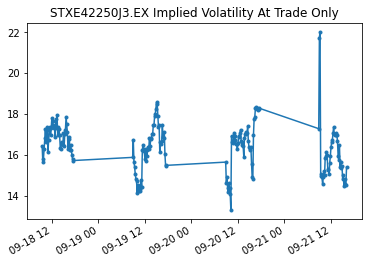

In [77]:
display(closest_atm_optn)
IPADfSimpleGraph = pd.DataFrame(
    data=IPADfGraph.ImpliedVolatility.values,
    index=IPADfGraph.ImpliedVolatility.index)

fig, ax = plt.subplots(ncols=1)

ax.plot(IPADfSimpleGraph, '.-')
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_title(
    f"{closest_atm_optn.RIC.values[0]} Implied Volatility At Trade Only")
fig.autofmt_xdate()

plt.show()

#### At Trade Data

Note here that we are now looking only 'At Trade', i.e.: times when the option traded, not the underlying. There are therefore fewer datapoints.

##### Overlay

In [78]:
IPADfGraph = ATIPADf[[
    'ImpliedVolatility', f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}",
    'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
    'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']].droplevel('gmt')

In [79]:
display(closest_atm_optn)

fig = px.line(IPADfGraph)  # This is just to see the implied vol graph when that field is available
# fig.layout = dict(xaxis=dict(type="category"))

# Format Graph: https://plotly.com/python/tick-formatting/
fig.update_layout(
    title=instrument,
    template='plotly_dark')

# Make it so that only one line is shown by default: # https://stackoverflow.com/questions/73384807/plotly-express-plot-subset-of-dataframe-columns-by-default-and-the-rest-as-opt
fig.for_each_trace(
    lambda t: t.update(
        visible=True if t.name in IPADfGraph.columns[:1] else "legendonly"))

# Add shade in Non Trading Hours
shapes = [
    {'type': "rect", 'xref': 'x', 'yref': 'paper',
     'fillcolor': 'purple', 'opacity': 0.4,
     "line": {"color": "purple", "width": 0},
     'x0': i[0], 'y0': 0,
     'x1': i[1], 'y1': 1}
     for i in Get_ooth(df=IPADfGraph, tz=None)]

fig.update_layout(shapes=shapes,)


fig.show()

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


##### Sack of 3 Graphs
This representation will allow us to see several graphs at different scales stacked above one another. This way, we can see if the change in Implied Volatility is caused by a movement in the underlying or the Option price itself:

In [80]:
display(closest_atm_optn)

fig = subplots.make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(
    x=IPADfGraph.index, y=IPADfGraph.ImpliedVolatility,
    name='Op Imp Volatility'), row=1, col=1)
fig.add_trace(go.Scatter(
    y=IPADfGraph[f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"],
    x=IPADfGraph.index,
    name=f"OptnMrktValueInDealCcy-{__optn_mrkt_price_gmt.columns[0]}"), row=2, col=1)
fig.add_trace(go.Scatter(
    x=IPADfGraph.index, y=IPADf.UnderlyingPrice,
    name=underlying + ' Undrlyg Pr'), row=3, col=1)


fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(title=IPADfGraph.columns.name)

fig.update_layout(
    template='plotly_dark',
    autosize=False,
    width=1300,
    height=500,
    shapes = [ # Adding purple area on out of trading hours
        {'type': "rect", 'xref': 'x', 'yref': 'paper',
        'fillcolor': 'purple', 'opacity': 0.2,
        "line": {"color": "purple", "width": 0},
        'x0': i[0], 'y0': 0,
        'x1': i[1], 'y1': 1}
        for i in Get_ooth(df=IPADfGraph, tz=None)])

fig.show()

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


##### Simple Graph

Certain companies are slow to update libraries, dependencies or Python versions. They/You may thus not have access to plotly (the graph library we used above). Matplotlib is rather light and should work, even on machines with old setups:

,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC,InsertDateTime,RetireDate
6,Eurex EURO STOXX 50 Monthly Index Option 4225 ...,STXE42250J3.EX,4225,EUX,2023-10-20,[.STOXX50E],2023-03-09 03:54:51,2023-10-24


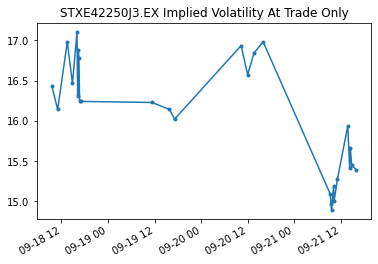

In [81]:
display(closest_atm_optn)
IPADfSimpleGraph = pd.DataFrame(
    data=IPADfGraph.ImpliedVolatility.values,
    index=IPADfGraph.ImpliedVolatility.index)

fig, ax = plt.subplots(ncols=1)

ax.plot(IPADfSimpleGraph, '.-')
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_title(
    f"{closest_atm_optn.RIC.values[0]} Implied Volatility At Trade Only")
fig.autofmt_xdate()

plt.show()